# 1. Load and Visualize the Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from tqdm import tqdm

In [ ]:
# Définition des transformations
transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor()
])

batch_size = 512

# Chargement complet du dataset
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
val_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

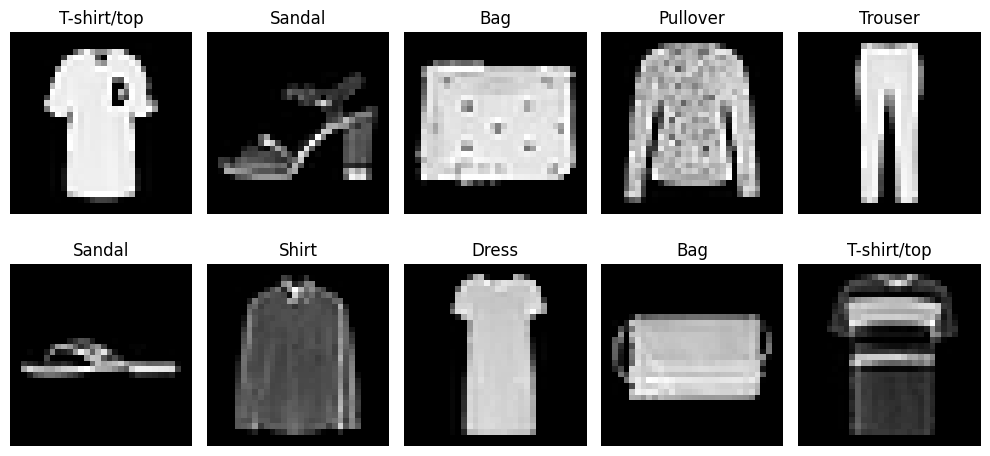

In [3]:
class_labels = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

def plot_sample_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images.numpy()

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(class_labels[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_sample_images(train_loader)

# 2. Build the Autoencoder

**a. How does reducing the dimensionality help the model?**

It forces the model to capture essential data features, removing noise and redundancy. This improves generalization and reduces processing complexity.

<hr>

**b. What happens if the latent space is too small or too large?**

- Too small → Loss of important information, poor reconstructions.
- Too large → Stores too much information, risk of overfitting.

In [4]:
# Define the Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_shape=(1, 32, 32), latent_dim=2):
        """
        Initialize the Autoencoder model.
        - input_shape: The shape of the input images (1, 32, 32) for grayscale images.
        - latent_dim: The number of neurons in the latent space.
        """
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # First convolutional layer: Convert 1-channel input into 32 feature maps.
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(), # activation function

            # Second convolutional layer: Reduce spatial dimensions further.
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(), #activation function

            # Third convolutional layer: Extract higher-level features.
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Add another Conv2D layer with 128 filters, kernel size 3, stride 2, padding 1
            nn.ReLU()  #activation function

        )

        # Dynamically calculate the flattened size after encoding
        flattened_size, decode_shape = self.calculate_flattened_size(self.encoder, input_shape)

        # Latent space (fully connected layer)
        self.fc = nn.Sequential(
            nn.Flatten(start_dim=1),  # Flatten the encoded features
            nn.Linear(flattened_size, latent_dim)  # Replace xxx with the latent dimension
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, flattened_size),  # Map latent space back to the feature map
            nn.Unflatten(decode_shape[0],decode_shape[1:]),  # Reshape to match the encoded feature map
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # Add a conv transpose 2d
            nn.ReLU(), # activation function


            # Next deconvolution layer
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Add a ConvTranspose2d layer reducing from 64 channels to 32 channels and  kernel_size=3, stride=2, padding=1, output_padding=1
            nn.ReLU(), # activation function

            # Final deconvolution layer: Convert back to single-channel grayscale image
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # activation function
            # Output values should be between 0 and 1
        )

    def calculate_flattened_size(self, model, input_shape):
        """
        Helper function to determine the flattened size after the encoder.
        - model: The encoder model.
        - input_shape: The shape of the input tensor.
        Returns:
        - The flattened size (number of features) and output shape.
        """
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)  # Create a batch of one image
            output = model(dummy_input)
            return output.numel(), output.shape  # Return total number of elements and shape

    def forward(self, x):
        """
        Forward pass through the Autoencoder.
        - x: Input image tensor.
        Returns:
        - Reconstructed image
        - Latent space representation
        """
        x = self.encoder(x)  # Pass through the encoder
        latent = self.fc(x)  # Project into latent space
        x = self.decoder(latent)  # Decode the latent representation
        return x, latent

In [5]:
# Test dimension consistency
x_sample = torch.randn(1, 1, 32, 32)  # Example input
model_test = Autoencoder()
image_test,latent_space = model_test(x_sample)
assert image_test.shape == x_sample.shape, "Output dimensions do not match input dimensions!"

# 3. Train the Autoencoder

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, epochs):
    """
    Train the Autoencoder model.

    - model: The Autoencoder instance.
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    - epochs: Number of training iterations.
    """

    model.to(device)# Move model to device
    optimizer = optim.Adam(model.parameters(), lr=1e-5) # Choose a suitable learning rate
    loss_fn = nn.MSELoss() # Define the loss function
    print("Start Training...")
    # Lists to store loss values for plotting
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train() # Set model to training mode
        total_loss = 0
        tqdm_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for x, _ in tqdm_loader:
            x = x.to(device) # Move batch to device
             # Forward pass: get reconstructed output
            recon_x, _ = model(x)
            # Compute reconstruction loss loss = xxx  # Compute MSE loss between `recon_x` and `x`
            loss = loss_fn(recon_x, x)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward() # Compute gradients
            optimizer.step() # Update weights

            total_loss += loss.item() # Accumulate batch loss
	    # Update tqdm progress bar with loss
            tqdm_loader.set_postfix(loss=loss.item())

        # Calculate average loss over the epoch
        avg_train_loss = total_loss / len(train_loader.dataset)
	    # for val get Mean Squared Error and cross_entropy
        avg_val_loss,ce_losss = evaluate_model(model, val_loader)
        # Store losses for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)


        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {100*avg_train_loss:.6f} %, Val Loss: {100*avg_val_loss:.6f} %,  Val Loss cross_entropy: {100*ce_losss:.6f} %")
    # Plot training and validation loss
    plot_training_loss(train_losses, val_losses)


def evaluate_model(model, loader):
    """
    Evaluate the model on validation data.

    - model: Trained Autoencoder model.
    - loader: DataLoader for validation data.

    Returns:
    - avg_loss: The average loss across all validation samples.
    """
    model.eval() # Set model to evaluation mode
    total_loss = 0
    loss_fn = nn.MSELoss() # Use the same loss function as training
    ce_losss=0
    with torch.no_grad():  # No need to compute gradients
        for x, _ in tqdm(loader, desc="Evaluating"):
            x = x.to(device)
            recon_x,_ = model(x) # Get reconstruction
            loss = loss_fn(recon_x, x) # Compute loss between recon_x and x
            ce_loss= F.binary_cross_entropy(recon_x, x)
            total_loss += loss.item()
            ce_losss+=ce_loss

    avg_loss = total_loss / len(loader.dataset)
    ce_losss/=len(loader.dataset)
    return avg_loss,ce_losss

def plot_training_loss(train_losses, val_losses):
    """
    Plot the training and validation loss across epochs.

    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", marker="o")
    plt.plot(val_losses, label="Validation Loss", marker="s")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

Start Training...


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.26it/s]


Epoch [1/10], Train Loss: 0.024749 %, Val Loss: 0.014179 %,  Val Loss cross_entropy: 0.081909 %


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.13it/s]


Epoch [2/10], Train Loss: 0.013008 %, Val Loss: 0.011775 %,  Val Loss cross_entropy: 0.073333 %


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.05it/s]


Epoch [3/10], Train Loss: 0.009713 %, Val Loss: 0.008576 %,  Val Loss cross_entropy: 0.064404 %


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.01it/s]


Epoch [4/10], Train Loss: 0.007785 %, Val Loss: 0.007412 %,  Val Loss cross_entropy: 0.061542 %


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.17it/s]


Epoch [5/10], Train Loss: 0.007013 %, Val Loss: 0.006899 %,  Val Loss cross_entropy: 0.060146 %


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.09it/s]


Epoch [6/10], Train Loss: 0.006649 %, Val Loss: 0.006629 %,  Val Loss cross_entropy: 0.059518 %


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 13.89it/s]


Epoch [7/10], Train Loss: 0.006425 %, Val Loss: 0.006434 %,  Val Loss cross_entropy: 0.058934 %


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.09it/s]


Epoch [8/10], Train Loss: 0.006267 %, Val Loss: 0.006304 %,  Val Loss cross_entropy: 0.058520 %


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.07it/s]


Epoch [9/10], Train Loss: 0.006158 %, Val Loss: 0.006201 %,  Val Loss cross_entropy: 0.058239 %


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 14.07it/s]


Epoch [10/10], Train Loss: 0.006076 %, Val Loss: 0.006124 %,  Val Loss cross_entropy: 0.057981 %


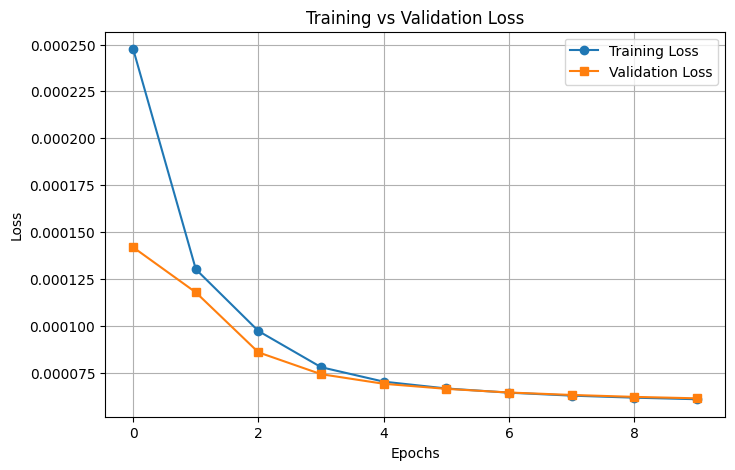

In [10]:
# Instantiate and train the model
autoencoder = Autoencoder()
train_model(autoencoder, train_loader, val_loader, epochs=10)

# 4. Reconstruct Images Using the Autoencoder

(60000, 2)


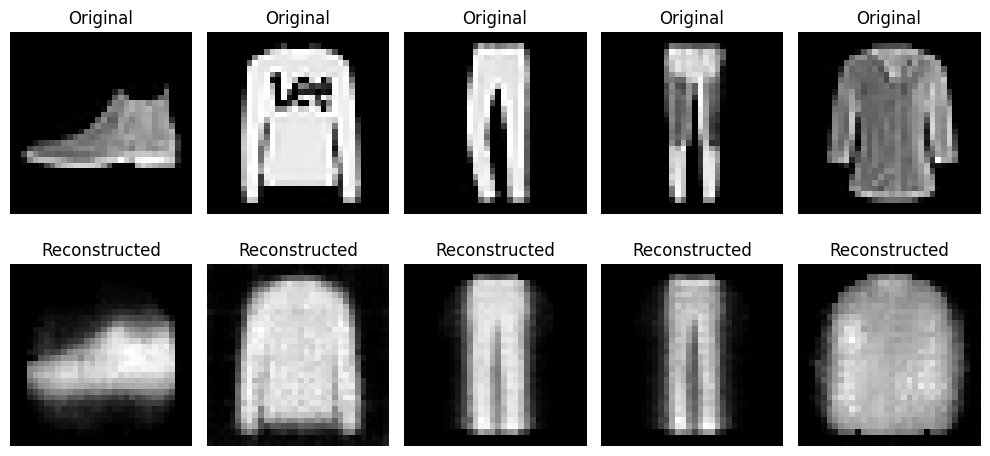

In [11]:
# Function to plot reconstructions
def plot_reconstructions(model, loader, ex=True):
    model.eval()  # Set the model to evaluation mode
    model = model.to("cpu")  # Move model to CPU for visualization

    with torch.no_grad():
        if ex:
            for x, _ in loader:  # Extract a batch from DataLoader
                recon_x, _ = model(x)
                break
        else:
            x = loader  # Directly use provided latent vectors
            recon_x = model.decoder(x)  # Decode latent space samples

    # Convert tensors to NumPy for plotting
    x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

    plt.figure(figsize=(10, 5))
    for i in range(5):
        # Plot Original images (only if batch came from real data)
        if ex:
            plt.subplot(2, 5, i + 1)
            plt.imshow(x[i].squeeze(), cmap="gray")
            plt.title("Original")
            plt.axis("off")

        # Plot Reconstructed images
        plt.subplot(2, 5, i + 6)
        plt.imshow(recon_x[i].squeeze(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Initialize lists to store embeddings and corresponding labels
embeddings = []
labels = []

# Move the Autoencoder to the appropriate device
autoencoder = autoencoder.to(device)
# Disable gradient computation for efficiency
with torch.no_grad():
    for x, y in train_loader:  # Iterate over training batches
        x = x.to(device)  # Move batch to device
        # Pass the images through the encoder to get latent space representations
        _, latent = autoencoder(x)  # Replace xxx to correctly call the Autoencoder and extract embeddings
        # Convert to NumPy and store results
        embeddings.append(latent.cpu().numpy())
        labels.append(y.numpy())

# Combine embeddings and labels into single arrays
embeddings = np.concatenate(embeddings, axis=0)  # Use NumPy to concatenate the embeddings along axis 0
print(embeddings.shape)
labels = np.concatenate(labels, axis=0)  # Similarly, concatenate the labels

# Identify unique class labels
unique_labels = np.unique(labels)
autoencoder=autoencoder.to("cpu")

# Generate latent space samples for visualization
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = torch.tensor(np.random.uniform(mins, maxs, size=(5, 2)), dtype=torch.float32)

plot_reconstructions(autoencoder, val_loader)

# 5. Visualize the Latent Space

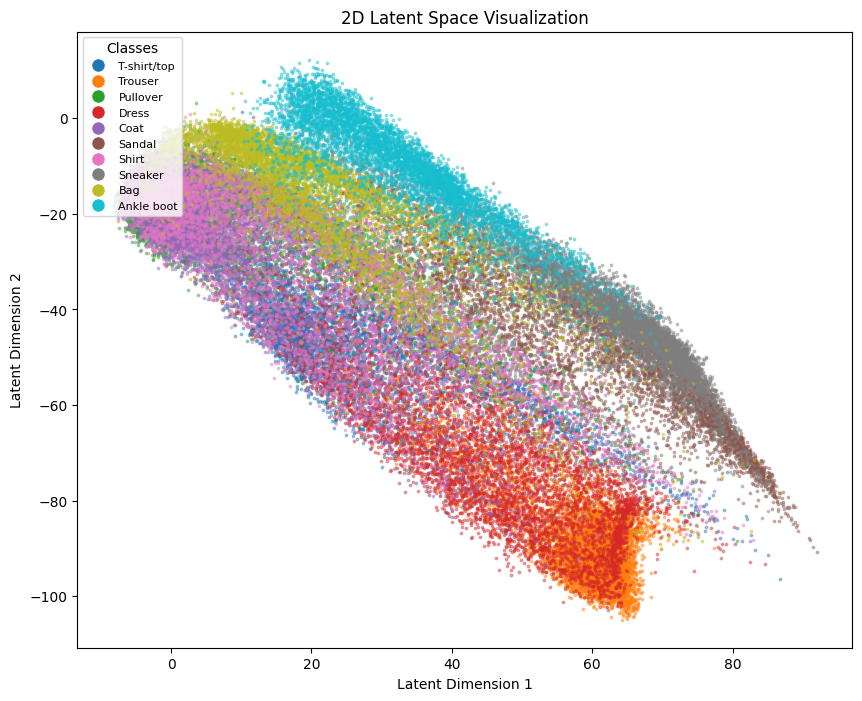

In [12]:
# Plot the 2D embeddings

# Generate more distinguishable colors for each class using a categorical colormap
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

# Scatter plot
plt.figure(figsize=(10, 8))
legend_handles = []
for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)[0]
    scatter = plt.scatter(
        embeddings[indices, 0], embeddings[indices, 1],
        c=[colors[i]], alpha=0.4, s=3, label=class_labels[label]
    )
    legend_handles.append(
        Line2D([0], [0], marker='o', color='w', label=f'{class_labels[label]}',
               markersize=10, markerfacecolor=colors[i])
    )

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization')
plt.legend(handles=legend_handles, title='Classes', loc='upper left', fontsize=8)
plt.show()

# 6. Generate New Images Using the Decoder

Generated Latent Samples:
 tensor([[ -2.4519, -20.3536],
        [ 66.3351,  -5.6301],
        [ 43.2447, -39.8185],
        [ -3.2165, -99.3238],
        [ 90.5522, -89.6056]])


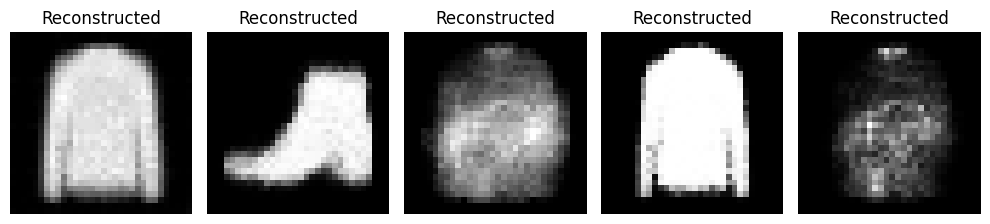

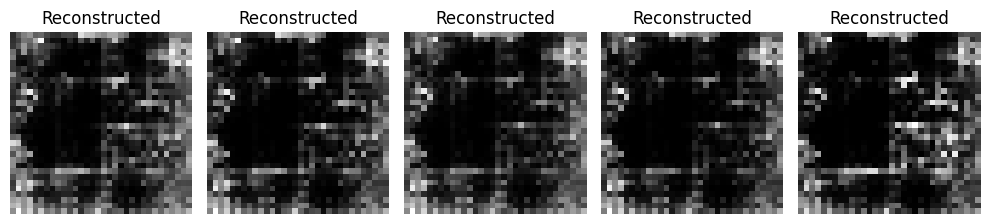

In [13]:
# Generate latent space samples for visualization
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = torch.tensor(np.random.uniform(mins, maxs, size=(5, 2)), dtype=torch.float32)

# Print the sampled latent vectors
print("Generated Latent Samples:\n", sample)

# Plot reconstructions from sampled latent space
plot_reconstructions(autoencoder, sample, ex=False)

x_sample = torch.tensor([[0.,20],[0.,25],[-2.,20],[-2.,25],[5.,30]]) # Example input
plot_reconstructions(autoencoder, x_sample, ex=False)

#save the model
torch.save(autoencoder.state_dict(), "VAmodel_state_dict.pth")